## Lasso regression for sparse data

In [2]:
%load_ext autoreload
%autoreload 2

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import class_FM as FM
from sklearn import preprocessing
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans


### Initialize factorial model and sample dataset for k=3

In [84]:
n = 10000
k = 3
degree = 3
sigma = 0.3
sparsity = 0.5

fm = FM.FactorialModel(
    n=n,
    k=k,
    degree=degree,
    sigma=sigma,
    sparsity=sparsity,
    beta_seed=40,
    heredity = True
)
t, y = fm.sample(seed=0)
print(fm.beta)

[-1.1420923  -1.0693365  -0.7572575   0.7686581  -1.0379355  -1.0260364
 -0.39261925  1.3877289 ]
[1]
[[1. 0. 1.]]
[[1. 1. 0. 1. 0. 1. 0. 0.]]
[-1.1420923 -1.0693365 -0.         0.7686581 -0.        -1.0260364
 -0.         0.       ]


### Cross Validation Search for Alpha


In [85]:
pf = preprocessing.PolynomialFeatures(
    degree=degree, interaction_only=True, include_bias=True,
)
T = pf.fit_transform(t)
T_train, T_test, y_train, y_test = train_test_split(T, y, test_size=0.3, random_state=42)
alpha_cv = [0.001,0.01,0.1, 0.5]
model = LassoCV(alphas = alpha_cv, cv=5, random_state=42)
model.fit(T_train, y_train)
alpha = model.alpha_


### Fit Lasso regression with sample data

In [86]:

model = Lasso(alpha=0.01)
model.fit(T_train, y_train)
print(model.coef_)

[ 0.         -1.1265124   0.          0.63419414 -0.         -0.8467384
  0.         -0.        ]


### Compute expected outcomes as linear combinations of betas

In [87]:
betas = model.coef_
print(betas)
print(fm.beta)
beta_mask = pf.transform(pf.powers_)
print(beta_mask)
expected_outcomes = beta_mask @ betas
print(expected_outcomes)

[ 0.         -1.1265124   0.          0.63419414 -0.         -0.8467384
  0.         -0.        ]
[-1.1420923 -1.0693365 -0.         0.7686581 -0.        -1.0260364
 -0.         0.       ]
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 1. 0. 1. 0. 0.]
 [1. 0. 1. 1. 0. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]
[ 0.         -1.12651241  0.          0.63419414 -1.12651241 -1.33905667
  0.63419414 -1.33905667]


### Plot betas and expected outcomes

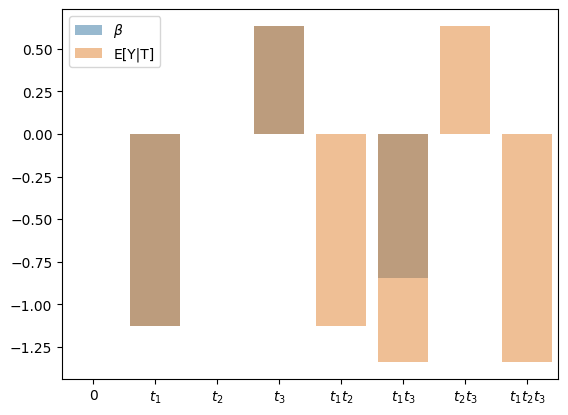

In [88]:
_ = sns.barplot(
    x=[
        r"0",
        r"$t_1$",
        r"$t_2$",
        r"$t_3$",
        r"$t_1 t_2$",
        r"$t_1 t_3$",
        r"$t_2 t_3$",
        r"$t_1 t_2 t_3$",
    ],
    y=betas,
    alpha=0.5,
    label=r"$\beta$",
)

_ = sns.barplot(
    x=[
        r"0",
        r"$t_1$",
        r"$t_2$",
        r"$t_3$",
        r"$t_1 t_2$",
        r"$t_1 t_3$",
        r"$t_2 t_3$",
        r"$t_1 t_2 t_3$",
    ],
    y=expected_outcomes,
    alpha=0.5,
    label=r"E[Y|T]",
)

### Cluster with KMeans Algorithm


In [94]:
# print(expected_outcomes)
def cross_val_kmeans(T_train: np.array, T_test: np.array, y_train: np.array,y_test: np.array, expected_outcomes: np.array,beta_mask:np.array,  max_clust:int)->dict:
    k_means_mse = {}
    # print(expected_outcomes)
    cluster_dict = {}
    
    for i in range(1,max_clust+1):
        kmeans = KMeans(n_clusters=i, random_state=0, n_init="auto").fit(expected_outcomes.reshape(-1,1))
        clusters_train = kmeans.predict(y_train.reshape(-1,1))
        # clusters_test = kmeans.predict(y_test.reshape(-1,1))
        for row in range(beta_mask.shape[0]):
            #convert binary combination to decimal to make a dictionary and map each combo to a group
            cluster_dict[beta_mask[row].dot(2**np.arange(beta_mask[row].size)[::-1])] = kmeans.labels_[row]
        mse = 0
        
        #decimalize all combinations
        powers_of_two = 2**np.arange(beta_mask.shape[1])[::-1]
        dec_test = T_test.dot(powers_of_two)
        combo_dict = { key: 0 for key in range(i)}
        eo_train = {}
        for k in range(i):
            eo_train[k] = np.mean(y_train[clusters_train==k])
        for key,value in cluster_dict.items():
            combo_dict[value] += np.sum((y_test[dec_test==key] - eo_train[value])**2)
        k_means_mse[i] = sum(combo_dict.values())
        print("For {} Clusters, MSE:{}".format(i,sum(combo_dict.values())))
        print("Clusters for each combination: {}".format(kmeans.labels_))
    return k_means_mse
values = cross_val_kmeans(T_train, T_test,y_train, y_test,expected_outcomes, beta_mask,4)

For 1 Clusters, MSE:2370.727622666274
Clusters for each combination: [0 0 0 0 0 0 0 0]
For 2 Clusters, MSE:1473.520783649019
Clusters for each combination: [1 0 1 1 0 0 1 0]
For 3 Clusters, MSE:1591.9996825640742
Clusters for each combination: [2 0 2 1 0 0 1 0]
For 4 Clusters, MSE:2580.3394681168165
Clusters for each combination: [2 0 2 1 0 3 1 3]


{1: 2370.727622666274, 2: 1473.520783649019, 3: 1591.9996825640742, 4: 2580.3394681168165}


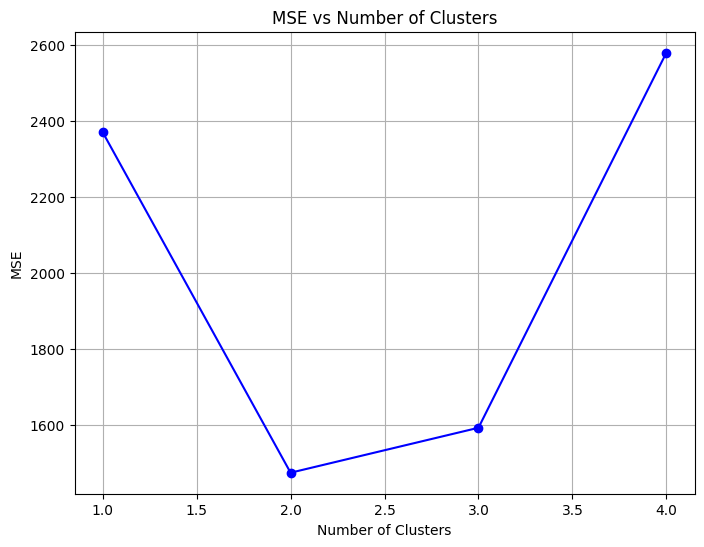

In [97]:

import matplotlib.pyplot as plt
print(values)
x = list(values.keys())
y = list(values.values())
plt.figure(figsize=(8, 6))  # Optional: specify the figure size
plt.plot(x, y, marker='o', linestyle='-', color='b')  # Plot with line and markers

# Add title and labels
plt.title('MSE vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('MSE')

# Optional: Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()

### Factorial model and sample dataset for k=4

In [99]:
n = 1000
k = 4
degree = 4
sigma = 0.1
sparsity = 0.5

fm = FM.FactorialModel(
    n=n,
    k=k,
    degree=degree,
    sigma=sigma,
    sparsity=sparsity,
    beta_seed=42,
)
t, y = fm.sample(seed=0)

[ 0.3047171  -1.0399841   0.7504512   0.9405647  -1.9510351  -1.3021795
  0.1278404  -0.3162426  -0.01680116 -0.8530439   0.879398    0.7777919
  0.0660307   1.1272413   0.46750933 -0.85929245]
[ 4 11  9  0 10 12 13  5]


In [100]:
# Fit Lasso regression
pf = preprocessing.PolynomialFeatures(
    degree=degree, interaction_only=True, include_bias=True,
)
T = pf.fit_transform(t)
T_train, T_test, y_train, y_test = train_test_split(T, y, test_size=0.3, random_state=42)
alpha_cv = [0.001,0.01,0.1, 0.5]
model = LassoCV(alphas = alpha_cv, cv=5, random_state=42)
model.fit(T_train, y_train)
alpha = model.alpha_

model = Lasso(alpha=alpha)
model.fit(T_train, y_train)
print(model.coef_)
print(fm.beta)

[ 0.         -1.0383812   0.74151677  0.92653066  0.         -0.01760102
  0.12800655 -0.30126548  0.          0.01136997  0.00642461 -0.
 -0.02599995 -0.          0.42120025 -0.8189125 ]
[ 0.         -1.0399841   0.7504512   0.9405647   0.          0.
  0.1278404  -0.3162426  -0.01680116  0.          0.          0.
  0.          0.          0.46750933 -0.85929245]


In [101]:
# Compute expected outcomes
betas = model.coef_
beta_mask = pf.fit_transform(pf.powers_)
expected_outcomes = beta_mask @ betas
print(expected_outcomes)

[ 0.         -1.03838122  0.74151677  0.92653066  0.         -0.31446547
  0.01615599 -1.3396467   1.66804743  0.75288674  0.93295527  0.74007173
 -0.63036092 -0.27868488  2.10704226  0.03288864]


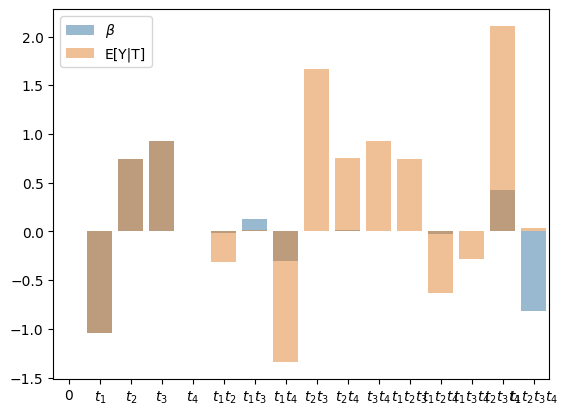

In [102]:
# Plot betas and expected outcomes
_ = sns.barplot(
    x=[
        r"0",
        r"$t_1$",
        r"$t_2$",
        r"$t_3$",
        r"$t_4$",
        r"$t_1 t_2$",
        r"$t_1 t_3$",
        r"$t_1 t_4$",
        r"$t_2 t_3$",
        r"$t_2 t_4$",
        r"$t_3 t_4$",
        r"$t_1 t_2 t_3$",
        r"$t_1 t_2 t_4$",
        r"$t_1 t_3 t_4$",
        r"$t_2 t_3 t_4$",
        r"$t_1 t_2 t_3 t_4$",
    ],
    y=betas,
    alpha=0.5,
    label=r"$\beta$",
)

_ = sns.barplot(
    x=[
        r"0",
        r"$t_1$",
        r"$t_2$",
        r"$t_3$",
        r"$t_4$",
        r"$t_1 t_2$",
        r"$t_1 t_3$",
        r"$t_1 t_4$",
        r"$t_2 t_3$",
        r"$t_2 t_4$",
        r"$t_3 t_4$",
        r"$t_1 t_2 t_3$",
        r"$t_1 t_2 t_4$",
        r"$t_1 t_3 t_4$",
        r"$t_2 t_3 t_4$",
        r"$t_1 t_2 t_3 t_4$",
    ],
    y=expected_outcomes,
    alpha=0.5,
    label=r"E[Y|T]",
)

### Find Kmeans clusters

In [103]:

values = cross_val_kmeans(T_train, T_test,y_train, y_test,expected_outcomes, beta_mask,15)

For 1 Clusters, MSE:226.62528202932663
Clusters for each combination: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
For 2 Clusters, MSE:69.98290663726938
Clusters for each combination: [0 0 1 1 0 0 0 0 1 1 1 1 0 0 1 0]
For 3 Clusters, MSE:44.821749973392706
Clusters for each combination: [0 0 1 1 0 0 0 0 2 1 1 1 0 0 2 0]
For 4 Clusters, MSE:12.365039650272358
Clusters for each combination: [3 0 1 1 3 3 3 0 2 1 1 1 0 3 2 3]
For 5 Clusters, MSE:9.027676808735215
Clusters for each combination: [3 4 1 1 3 3 3 4 2 1 1 1 0 3 2 3]
For 6 Clusters, MSE:5.835281616594306
Clusters for each combination: [3 4 1 1 3 5 3 4 2 1 1 1 0 5 2 3]
For 7 Clusters, MSE:4.2762259123037465
Clusters for each combination: [3 4 1 1 3 5 3 4 6 1 1 1 0 5 2 3]
For 8 Clusters, MSE:3.812945890371637
Clusters for each combination: [3 4 7 1 3 5 3 4 6 7 1 7 0 5 2 3]
For 9 Clusters, MSE:2.992498840140452
Clusters for each combination: [3 8 7 1 3 5 3 4 6 7 1 7 0 5 2 3]
For 10 Clusters, MSE:3.274679079121633
Clusters for each combination:

{1: 226.62528202932663, 2: 69.98290663726938, 3: 44.821749973392706, 4: 12.365039650272358, 5: 9.027676808735215, 6: 5.835281616594306, 7: 4.2762259123037465, 8: 3.812945890371637, 9: 2.992498840140452, 10: 3.274679079121633, 11: 3.7334673657358626, 12: 3.5756259096737377, 13: 3.8919978150417993, 14: 4.00887981730433, 15: 3.8731012787620718}


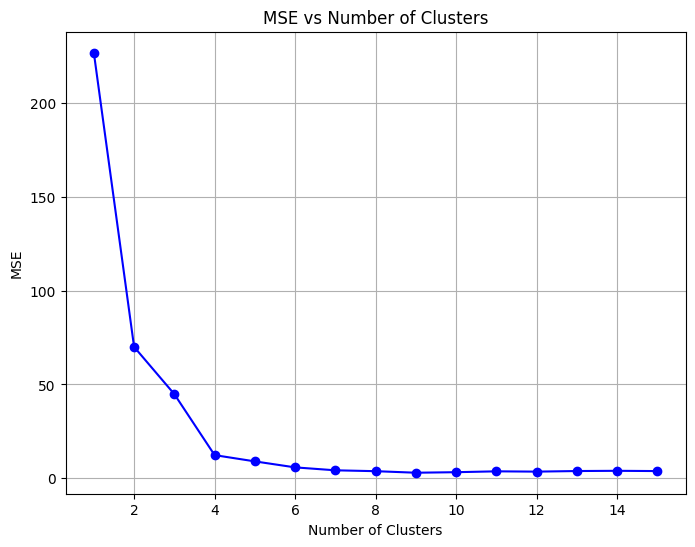

In [104]:
import matplotlib.pyplot as plt
print(values)
x = list(values.keys())
y = list(values.values())
plt.figure(figsize=(8, 6))  # Optional: specify the figure size
plt.plot(x, y, marker='o', linestyle='-', color='b')  # Plot with line and markers

# Add title and labels
plt.title('MSE vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('MSE')

# Optional: Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()

### Factorial model and sample dataset for k=5

In [57]:
n = 1000
k = 5
degree = 5
sigma = 0.1
sparsity = 0.5

fm = FM.FactorialModel(
    n=n,
    k=k,
    degree=degree,
    sigma=sigma,
    sparsity=sparsity,
    beta_seed=42,
)
t, y = fm.sample(seed=0)

In [58]:
# Fit Lasso regression
pf = preprocessing.PolynomialFeatures(
    degree=degree, interaction_only=True, include_bias=True,
)
T = pf.fit_transform(t)
model = Lasso(alpha=0.1)
model.fit(T, y)
print(model.coef_)

[ 0.          0.          0.45883626  0.         -0.         -0.
  0.          0.         -0.         -0.          0.41779137  0.
  0.          0.          0.         -0.33889037  0.          0.
  0.          0.          0.         -0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.
  0.          0.        ]


In [59]:
# Compute expected outcomes
betas = model.coef_
beta_mask = pf.fit_transform(pf.powers_)
expected_outcomes = beta_mask @ betas
print(expected_outcomes)

[ 0.          0.          0.45883626  0.          0.          0.
  0.45883626  0.          0.          0.          0.87662762  0.45883626
  0.45883626  0.          0.         -0.33889037  0.87662762  0.45883626
  0.45883626  0.          0.         -0.33889037  0.87662762  0.87662762
  0.11994588 -0.33889037  0.87662762  0.87662762  0.11994588 -0.33889037
  0.53773725  0.53773725]


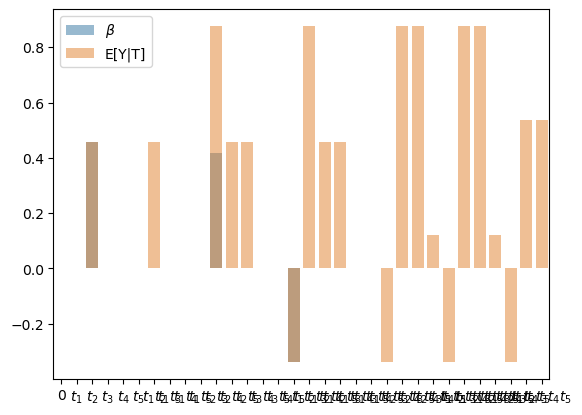

In [60]:
# Plot betas and expected outcomes
_ = sns.barplot(
    x=[
        r"0",
        r"$t_1$",
        r"$t_2$",
        r"$t_3$",
        r"$t_4$",
        r"$t_5$",
        r"$t_1 t_2$",
        r"$t_1 t_3$",
        r"$t_1 t_4$",
        r"$t_1 t_5$",
        r"$t_2 t_3$",
        r"$t_2 t_4$",
        r"$t_2 t_5$",
        r"$t_3 t_4$",
        r"$t_3 t_5$",
        r"$t_4 t_5$",
        r"$t_1 t_2 t_3$",
        r"$t_1 t_2 t_4$",
        r"$t_1 t_2 t_5$",
        r"$t_1 t_3 t_4$",
        r"$t_1 t_3 t_5$",
        r"$t_1 t_4 t_5$",
        r"$t_2 t_3 t_4$",
        r"$t_2 t_3 t_5$",
        r"$t_2 t_4 t_5$",
        r"$t_3 t_4 t_5$",
        r"$t_1 t_2 t_3 t_4$",
        r"$t_1 t_2 t_3 t_5$",
        r"$t_1 t_2 t_4 t_5$",
        r"$t_1 t_3 t_4 t_5$",
        r"$t_2 t_3 t_4 t_5$",
        r"$t_1 t_2 t_3 t_4 t_5$",
    ],
    y=betas,
    alpha=0.5,
    label=r"$\beta$",
)

_ = sns.barplot(
    x=[
        r"0",
        r"$t_1$",
        r"$t_2$",
        r"$t_3$",
        r"$t_4$",
        r"$t_5$",
        r"$t_1 t_2$",
        r"$t_1 t_3$",
        r"$t_1 t_4$",
        r"$t_1 t_5$",
        r"$t_2 t_3$",
        r"$t_2 t_4$",
        r"$t_2 t_5$",
        r"$t_3 t_4$",
        r"$t_3 t_5$",
        r"$t_4 t_5$",
        r"$t_1 t_2 t_3$",
        r"$t_1 t_2 t_4$",
        r"$t_1 t_2 t_5$",
        r"$t_1 t_3 t_4$",
        r"$t_1 t_3 t_5$",
        r"$t_1 t_4 t_5$",
        r"$t_2 t_3 t_4$",
        r"$t_2 t_3 t_5$",
        r"$t_2 t_4 t_5$",
        r"$t_3 t_4 t_5$",
        r"$t_1 t_2 t_3 t_4$",
        r"$t_1 t_2 t_3 t_5$",
        r"$t_1 t_2 t_4 t_5$",
        r"$t_1 t_3 t_4 t_5$",
        r"$t_2 t_3 t_4 t_5$",
        r"$t_1 t_2 t_3 t_4 t_5$",
    ],
    y=expected_outcomes,
    alpha=0.5,
    label=r"E[Y|T]",
)